In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.filters import gaussian 
import skimage.color as color
from skimage import io
from skimage.color import rgb2gray
from skimage.segmentation import active_contour
from skimage import segmentation
from skimage import morphology
from skimage import data

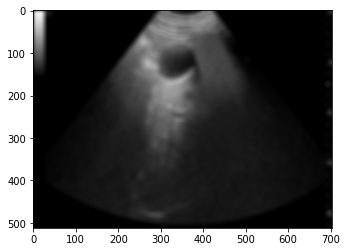

In [2]:
import cv2, scipy
import numpy as np
import sys
import scipy
from scipy.sparse.linalg import LinearOperator
	
class Mumfordshah():
	def __init__(self, img, iterations = 1, solver_maxiterations = 10, alpha = 1000, beta = 1000, epsilon = 0.001):
		self.iterations = iterations
		self.g = np.float64(img) / np.max(img) #toutes les pixels sur le max des pixels
		self.f = self.g
		self.edges = np.zeros(img.shape)#Renvoie un nouveau tableau de forme et de type donnés, rempli de zéros.
		self.update_gradients()		
		self.alpha, self.beta, self.epsilon = alpha, beta, epsilon
		self.add_const = self.beta / (4 * self.epsilon)
		self.multiply_const = self.epsilon * self.beta
		self.maxiter = solver_maxiterations

	def update_gradients(self):
		self.grad_x, self.grad_y = self.gradients(self.f)
		self.gradient_mag = np.power(self.grad_x, 2) + np.power(self.grad_y, 2)

	def edge_linear_operator(self, input):
		v = input.reshape(*self.g.shape)
		result = np.multiply(v, self.gradient_mag * self.alpha + self.add_const) \
				- self.multiply_const* cv2.Laplacian(v, cv2.CV_64F)

		return result.reshape(*input.shape)

	def image_linear_operator(self, input):
		f = input.reshape(*self.g.shape)

		x, y = self.gradients(f)

		result = f - 2*self.alpha * (self.calc_grad_x(np.multiply(self.edges, x)) + self.calc_grad_y(np.multiply(self.edges, y)) )
		return result.reshape(*input.shape)

	def solve_edges(self):
		size = self.g.shape[0]* self.g.shape[1]
		A = LinearOperator( (size, size), matvec = self.edge_linear_operator, dtype = np.float64)
		b = np.ones(size) * self.beta / (4 * self.epsilon)

		self.edges, _ = scipy.sparse.linalg.cg(A, b, maxiter = self.maxiter)
		self.edges = np.power(self.edges.reshape(*self.g.shape), 2)
		return self.edges

	def solve_image(self):
		size = self.g.shape[0]* self.g.shape[1]
		A = LinearOperator( (size, size), matvec = self.image_linear_operator, dtype = np.float64)
		b = self.g.reshape(size)

		self.f, _ = scipy.sparse.linalg.cg(A, b, maxiter = self.maxiter)
		self.f = self.f.reshape(*self.g.shape)
		self.update_gradients()
		return self.f

	def minimize(self):
		for i in range(0, self.iterations):
			self.solve_edges()
			self.solve_image()

		self.edges = np.power(self.edges, 0.5)
		cv2.normalize(self.f, self.f ,0,255,cv2.NORM_MINMAX)
		cv2.normalize(self.edges, self.edges ,0,255,cv2.NORM_MINMAX)
		self.f = np.uint8(self.f)
		self.edges = 255 - np.uint8(self.edges)

		return self.f, self.edges

	def calc_grad_x(self, img):
		return cv2.filter2D(img, cv2.CV_64F, np.array([[-1, 0, 1]]))

	def calc_grad_y(self, img):
		return cv2.filter2D(img, cv2.CV_64F, np.array([[-1, 0, 1]]).T)

	def gradients(self, img):
		return self.calc_grad_x(img), self.calc_grad_y(img)


def show_image(image, name):
	#img = image * 1
	cv2.normalize(img, img,0,255,cv2.NORM_MINMAX)
	#plt.imshow( img)

if __name__ == "__main__":
	img = cv2.imread("7_Vesicule.jpg")
	result, edges = [], []
	for channel in cv2.split(img):
		solver = Mumfordshah(channel, iterations = 1,  solver_maxiterations = 6)
		f5, v = solver.minimize()
		result.append(f5)
		edges.append(v)

f5 = cv2.merge(result)
plt.imshow(f5)
v = np.maximum(*edges)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.


"\nsnake = active_contour(f7,pt, alpha=0.001, beta= 10, gamma=0.001)\n\nax4 = fig.add_subplot(2,4,4)\nax4.plot(snake[:, 0], snake[:, 1], '-r', lw=3)\n\nax4.imshow(image7)\n\n\n\n\n\n\n\nfig.savefig('vesicule7.jpg')\n"

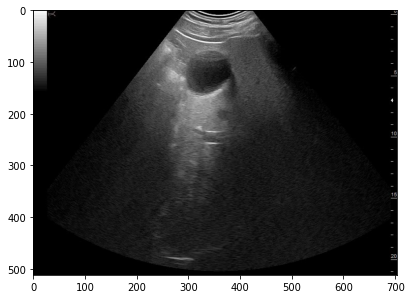

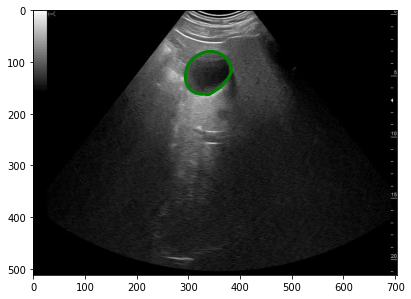

In [7]:
#coding:utf-8
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from pylab import*


image7=Image = cv2.imread('7_Vesicule.jpg',1)  

Image = image7.copy()  

fig = plt.figure(figsize=(30, 30))

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(Image)




#Lecture des coordonnées (x,y) 
point7 = pd.read_csv("point7.csv",sep=";")
R=[]
for i in range(len(point7)):
    x=int(point7.values[i][1])
    y=int(point7.values[i][2])
    R.append(x)
    R.append(y)
pts = np.ones((1,1), np.uint8)
pts = np.array([R])
pts = pts.reshape((-1,1,2))  
"""
#Dessiner le contour initial
imgCnt7 = cv2.polylines(Image, [pts], 1, (0,0,255),4)

ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgCnt)
"""
#Desiner le contour active
d=[]
e=[]
for i in range(len(point7)):
    x=int(point7.values[i][1])
    y=int(point7.values[i][2])
    d.append(x)
    e.append(y)
pt=np.array([d,e]).T
#image = cv2.cvtColor(imgCnt,cv2.COLOR_BGR2GRAY)


im=Image = cv2.imread('7_Vesicule.jpg',1)  

snake = active_contour(gaussian(im, 3),pt, alpha=0.001, beta= 10, gamma=0.001)
fig = plt.figure(figsize=(30, 30))

ax3 = fig.add_subplot(2,4,3)
#ax3.plot(pt[:, 0], pt[:, 1], '--b', lw=3)
ax3.plot(snake[:, 0], snake[:, 1], '-g', lw=3)
ax3.imshow(im)

#plot.savefig('plo.png')
fig.savefig('full_figure.png')
# Save just the portion _inside_ the second axis's boundaries

"""
snake = active_contour(f7,pt, alpha=0.001, beta= 10, gamma=0.001)

ax4 = fig.add_subplot(2,4,4)
ax4.plot(snake[:, 0], snake[:, 1], '-r', lw=3)

ax4.imshow(image7)







fig.savefig('vesicule7.jpg')
"""


In [8]:
def dice_coef(img, img2):
            if img.shape != img2.shape:
                raise ValueError("Shape mismatch: img and img2 must have to be of the same shape.")
            else:
                
                lenIntersection=0
                
                for i in range(img.shape[0]):
                    for j in range(img.shape[1]):
                        if ( np.array_equal(img[i][j],img2[i][j]) ):
                            lenIntersection+=1
                n=4        
                print(lenIntersection)
                lenimg=img.shape[0]*img.shape[1]
                lenimg2=img2.shape[0]*img2.shape[1]  
                value = (n* lenIntersection  / (lenimg + lenimg2))
            return value

In [ ]:
img=cv2.imread("Capturesnake7.PNG")
img = cv2.resize(img, dsize=(500,500))
fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(2,2,1)
plt.imshow(img)
ground_truth =cv2.imread("Capturegt7.PNG")
ground_truth = cv2.resize(ground_truth, dsize=(500,500))
ax1 = fig.add_subplot(2,2,2)

plt.imshow(ground_truth)
value=dice_coef(ground_truth,img)
print("\n")
print("                                              Coeff de dice de ",value)